In [1]:
import pandas as pd
pd.set_option('display.max_rows', 1000)

import numpy as np
from numpy import mean

import matplotlib.pyplot as plt

#turn off warnings for final run
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier


from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data Load and Preparation

In [3]:
#import sales csv
calls = pd.read_csv('cleaned_calls.csv')

In [4]:
#ceate column to indicate if call ended in sale based on customer existance
calls['sale'] = 0
calls.loc[calls['Zip'].notnull(), ['sale']] = 1

In [5]:
#only include a subset of the variables
calls_subset = calls[['Duration', 'Start Time', 'Keywords', 'Campaign', 'Page', 
                      'Device Type', 'Browser', 'Referrer', 'sale', 'State']]
calls_subset

,Duration,Start Time,Keywords,Campaign,Page,Device Type,Browser,Referrer,sale,State
0,167,12/22/2021 12:45,NaN,NaN,main/estate-planning-ppc/,mobile,Chrome,www.google.com,0,PA
1,115,12/22/2021 12:36,NaN,Medicaid - Elder Law - 001,NaN,NaN,NaN,NaN,0,IA
2,106,12/22/2021 12:23,NaN,NaN,main/,desktop,Chrome,direct,0,PA
3,33,12/22/2021 12:01,NaN,NaN,NaN,NaN,NaN,NaN,0,PA
4,112,12/22/2021 11:47,NaN,NaN,NaN,NaN,NaN,NaN,0,CA
...,...,...,...,...,...,...,...,...,...,...
1780,18,1/5/2021 8:47,NaN,NaN,NaN,NaN,NaN,NaN,0,PA
1781,44,1/5/2021 8:23,power of attorney will,Estate Planning 005,main/estate-planning-ppc/,desktop,Chrome,www.google.com,0,NY
1782,188,1/4/2021 14:28,NaN,NaN,NaN,NaN,NaN,NaN,1,PA
1783,91,1/4/2021 13:12,NaN,NaN,main/contact/,desktop,Chrome,www.google.com,0,MO


In [6]:
#convert start time to month and hour variables
calls_subset['Month'] = calls_subset['Start Time'].apply(lambda x: x.split(' ')[0].split('/')[0])
calls_subset['Hour'] = calls_subset['Start Time'].apply(lambda x: x.split(' ')[1].split(':')[0])
calls_subset = calls_subset.drop('Start Time', axis=1)
calls_subset

,Duration,Keywords,Campaign,Page,Device Type,Browser,Referrer,sale,State,Month,Hour
0,167,NaN,NaN,main/estate-planning-ppc/,mobile,Chrome,www.google.com,0,PA,12,12
1,115,NaN,Medicaid - Elder Law - 001,NaN,NaN,NaN,NaN,0,IA,12,12
2,106,NaN,NaN,main/,desktop,Chrome,direct,0,PA,12,12
3,33,NaN,NaN,NaN,NaN,NaN,NaN,0,PA,12,12
4,112,NaN,NaN,NaN,NaN,NaN,NaN,0,CA,12,11
...,...,...,...,...,...,...,...,...,...,...,...
1780,18,NaN,NaN,NaN,NaN,NaN,NaN,0,PA,1,8
1781,44,power of attorney will,Estate Planning 005,main/estate-planning-ppc/,desktop,Chrome,www.google.com,0,NY,1,8
1782,188,NaN,NaN,NaN,NaN,NaN,NaN,1,PA,1,14
1783,91,NaN,NaN,main/contact/,desktop,Chrome,www.google.com,0,MO,1,13


In [7]:
#remove rows without full data
calls_noNa = calls_subset.dropna().reset_index(drop=True)
print('Number of records: ' + str(calls_noNa.shape[0]))
print('Number of records with sale: ' + str(calls_noNa[calls_noNa['sale'] == 1].reset_index().shape[0]))

Number of records: 401
Number of records with sale: 48


## Get Dummies

In [8]:
#get raw value counts for variables
#for i in ['Keywords', 'Campaign', 'Page', 'Device Type', 'Browser', 'Referrer']:
#    print(calls_noNa[i].value_counts())

In [9]:
#update keyword categories to include at least 15 per category
keyword_categories = ['probate and estate administration lawyers',
'medicaid planning attorney',
'pittsburgh probate lawyers',
'elder law attorney',
'estate administration lawyer near me',
'pennsylvania lawyers']
calls_noNa['Keywords Categories'] = calls_noNa['Keywords']
calls_noNa.loc[~calls_noNa['Keywords'].isin(keyword_categories), 'Keywords Categories'] = 'Other Keywords'
calls_noNa = calls_noNa.drop('Keywords', axis=1)
calls_noNa['Keywords Categories'].value_counts()

Other Keywords                               288
probate and estate administration lawyers     25
medicaid planning attorney                    22
pittsburgh probate lawyers                    20
elder law attorney                            16
estate administration lawyer near me          15
pennsylvania lawyers                          15
Name: Keywords Categories, dtype: int64

In [10]:
#update page categories to include at least 15 per category
page_categories = ['elder-law-ppc/',
'estate-planning-ppc/',
'estate-admin-ppc/',
'main/',
'main/pittsburgh-estate-planning-lawyer/power-of-attorney-pittsburgh-pa/',
'main/firstname-redacted/',
'main/contact/']

calls_noNa['Page Categories'] = calls_noNa['Page']
calls_noNa.loc[~calls_noNa['Page'].isin(page_categories), 'Page Categories'] = 'Other Page'
calls_noNa = calls_noNa.drop('Page', axis=1)
calls_noNa['Page Categories'].value_counts()

Other Page                                                                 322
main/                                                                       28
main/pittsburgh-estate-planning-lawyer/power-of-attorney-pittsburgh-pa/     19
main/contact/                                                               16
main/firstname-redacted/                                                    16
Name: Page Categories, dtype: int64

In [11]:
#update browser categories to include at least 10 per category
browser_categories = ['Chrome', 'Safari']
calls_noNa['Browser Categories'] = calls_noNa['Browser']
calls_noNa.loc[~calls_noNa['Browser'].isin(browser_categories), 'Browser Categories'] = 'Firefox or Opera'
calls_noNa = calls_noNa.drop('Browser', axis=1)
calls_noNa['Browser Categories'].value_counts()

Chrome              214
Safari              176
Firefox or Opera     11
Name: Browser Categories, dtype: int64

In [12]:
#reduce state categories to PA or not PA
calls_noNa['State Categories'] = calls_noNa['State']
calls_noNa.loc[calls_noNa['State'] != 'PA', 'State Categories'] = 'Not PA'
calls_noNa = calls_noNa.drop('State', axis=1)
calls_noNa['State Categories'].value_counts()

PA        312
Not PA     89
Name: State Categories, dtype: int64

In [13]:
#lump all google values
calls_noNa.loc[calls_noNa['Referrer'] == 'cse.google.com', 'Referrer'] = 'www.google.com'

In [14]:
categorical = ['Keywords Categories', 'Campaign', 'Page Categories', 'Device Type', 'Browser Categories', 'Referrer', 'State Categories']
for i in categorical:
    dummies = pd.get_dummies(calls_noNa[i], drop_first=True)
    calls_noNa = pd.concat([calls_noNa,dummies],axis=1).dropna().reset_index(drop=True)
    calls_noNa = calls_noNa.drop(i, axis=1)
calls_noNa = calls_noNa.astype(int)
calls_noNa 

,Duration,sale,Month,Hour,elder law attorney,estate administration lawyer near me,medicaid planning attorney,pennsylvania lawyers,pittsburgh probate lawyers,probate and estate administration lawyers,...,Medicaid - Elder Law - 001,main/,main/contact/,main/firstname-redacted/,main/pittsburgh-estate-planning-lawyer/power-of-attorney-pittsburgh-pa/,mobile,Firefox or Opera,Safari,www.google.com,PA
0,224,1,12,10,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1
1,183,0,12,10,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,1
2,221,0,12,9,0,0,0,0,0,0,...,0,1,0,0,0,1,0,1,1,1
3,37,0,12,12,0,0,0,1,0,0,...,0,0,0,0,1,1,0,0,1,1
4,193,0,12,10,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
5,53,0,12,9,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,1,1
6,225,0,12,8,1,0,0,0,0,0,...,1,0,0,0,0,1,0,1,1,1
7,200,0,12,15,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,1
8,404,0,12,14,0,0,0,0,0,0,...,1,0,0,0,0,1,0,1,1,0
9,105,1,12,13,1,0,0,0,0,0,...,1,0,0,0,1,1,0,1,1,1


In [15]:
#check for and fix multicollinearity

vif_df = pd.DataFrame()
vif_df["feature"] = calls_noNa.columns
vif_df["VIF"] = [variance_inflation_factor(calls_noNa.values, i)
                          for i in range(len(calls_noNa.columns))]
  
print(vif_df)
print('\n')

calls_noNa = calls_noNa.drop('Hour', axis=1)
calls_noNa = calls_noNa.drop('www.google.com', axis=1)

vif_df = pd.DataFrame()
vif_df["feature"] = calls_noNa.columns
vif_df["VIF"] = [variance_inflation_factor(calls_noNa.values, i)
                          for i in range(len(calls_noNa.columns))]

print(vif_df)

                                              feature        VIF
0                                            Duration   1.795709
1                                                sale   2.022827
2                                               Month   5.896868
3                                                Hour  13.241278
4                                  elder law attorney   1.213769
5                estate administration lawyer near me   1.554053
6                          medicaid planning attorney   2.514512
7                                pennsylvania lawyers   1.176284
8                          pittsburgh probate lawyers   1.332965
9           probate and estate administration lawyers   1.351594
10                             Estate Admin - Overall   1.555531
11                                Estate Planning 005   3.392152
12                         Medicaid - Elder Law - 001   3.481524
13                                              main/   2.136406
14                       

# Perform Analysis

## Feature Selection

In [16]:
def feature_selection(X,y,model,cv,score):
    
    features_names=pd.DataFrame(X.columns)

    #perform RFECV and fit model to get rankings
    rfecv = RFECV(model, step=1, cv=cv, scoring=score) 
    fitted_values=rfecv.fit(X,y)
    ranks=pd.DataFrame(fitted_values.ranking_)

    rank=pd.concat([features_names,ranks], axis=1)
    rank.columns = ["Feature", "Rank"]

    #Select rank 1's
    most_important = rank.loc[rank['Rank'] ==1] 
    most_important = most_important['Feature']
    
    print('Most important features ('+str(len(most_important))+')')
    print(str(most_important))
    
    return most_important

## Analysis

In [17]:
def run_lr_model_split(df, n=5, score='f1', random_state=56):
        
    cv = StratifiedKFold(n_splits=n)    
    
    #split dataset into dependent and independent variables
    features = list(df.columns)  #all columns but sale
    features.remove('sale')
    X = df[features].astype('category') # Features
    y = df['sale'] # independent var

    # split X and y into test and train
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2, random_state=random_state)
    
    # instantiate the model
    model = LogisticRegression(max_iter=10000)

    # fit the model
    model.fit(X_train,y_train)
    
    #predict
    y_pred=model.predict(X_test)

    #create confusion matrix
    cMat = metrics.confusion_matrix(y_test, y_pred)
    
    print(cMat)

    print('Accuracy score with train/test: %.3f' % metrics.accuracy_score(y_test, model.predict(X_test))) #model accuracy
    print('Balanced Accuracy score with train/test: %.3f' % metrics.balanced_accuracy_score(y_test, model.predict(X_test))) #balanced model accuracy
    print('F1 score with train/test: %.3f' % metrics.f1_score(y_test, model.predict(X_test))) #model accuracy
    print('ROC AUC with train/test: %.3f' % metrics.accuracy_score(y_test, model.predict(X_test))) #model accuracy

    #metrics
    y_pred_prb = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_prb)

    #ROC curve plot
    plt.plot(fpr,tpr)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [18]:
def run_lr_model_cv(df, n=5, score='f1', random_state=56):
        
    cv = StratifiedKFold(n_splits=n)    
    
    #split dataset into dependent and independent variables
    features = list(df.columns)  #all columns but sale
    features.remove('sale')
    X = df[features].astype('category') # Features
    y = df['sale'] # independent var
    
    # instantiate the model
    model = LogisticRegression(max_iter=10000)
    
    #Setting the range for class weights
    weights = np.linspace(0.0,0.99,100)
    #Creating a dictionary grid for grid search
    param_grid = {'class_weight': [{0:x, 1:1.0-x} for x in weights]}

    #Fitting grid search to the train data with cv to find class weights
    gridsearch = GridSearchCV(estimator= model, 
                          param_grid= param_grid,
                          cv=cv, 
                          n_jobs=-1, 
                          scoring=score, 
                          verbose=2).fit(X, y)
        
    weight_df = pd.DataFrame({ 'score': gridsearch.cv_results_['mean_test_score'], 'weight': (1- weights)})
    optimum_weight = max(weight_df[weight_df['score'] == max(weight_df['score'])]['weight'])

    # re-instantiate the model
    model = LogisticRegression(max_iter=10000, random_state=random_state, 
                                       class_weight={0: 1-optimum_weight, 1: optimum_weight})
      
    #perform feature selection
    Best_X_Columns = feature_selection(X,y,model,n,score)
    X = X[Best_X_Columns]

    # fit the model
    #model.fit(X_train,y_train)
    
    #predict
    #y_pred=model.predict(X_test)
    
    # evaluate model with k-fold validation
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    bal_scores = cross_val_score(model, X, y, scoring='balanced_accuracy', cv=cv, n_jobs=-1)
    f1_scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
    w_f1_scores = cross_val_score(model, X, y, scoring='f1_weighted', cv=cv, n_jobs=-1)
    auc_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    
    # k-fold validiation acuracy
    print('Accuracy with K-Fold validation: %.3f' % (mean(scores)))
    print('Balanced Accuracy with K-Fold validation: %.3f' % (mean(bal_scores)))
    print('F1-Score with K-Fold validation: %.3f' % (mean(f1_scores)))
    print('ROC AUC with K-Fold validation: %.3f' % (mean(auc_scores)))
    
    return model

In [19]:
seed = np.random.randint(1000)
seed

204

[[72  1]
 [ 5  3]]
Accuracy score with train/test: 0.926
Balanced Accuracy score with train/test: 0.681
F1 score with train/test: 0.500
ROC AUC with train/test: 0.926


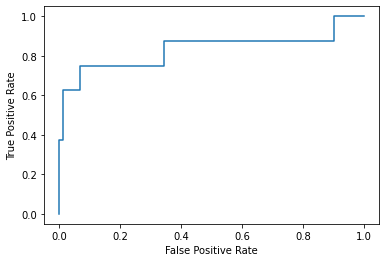

In [20]:
#linear regression, F1, CV = 5
run_lr_model_split(calls_noNa)

In [21]:
#linear regression, F1, CV = 5
run_lr_model_cv(calls_noNa)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Most important features (19)
0                                              Duration
1                                                 Month
2                                    elder law attorney
3                  estate administration lawyer near me
4                            medicaid planning attorney
5                                  pennsylvania lawyers
6                            pittsburgh probate lawyers
7             probate and estate administration lawyers
8                                Estate Admin - Overall
9                                   Estate Planning 005
10                           Medicaid - Elder Law - 001
11                                                main/
12                                        main/contact/
13                             main/firstname-redacted/
14    main/pittsburgh-estate-planning-lawyer/power-o...
15                                               mobile
16          

LogisticRegression(class_weight={0: 0.4, 1: 0.6}, max_iter=10000,
                   random_state=56)

In [22]:
#linear regression, F1, CV = 10
run_lr_model_cv(calls_noNa, n=10)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Most important features (19)
0                                              Duration
1                                                 Month
2                                    elder law attorney
3                  estate administration lawyer near me
4                            medicaid planning attorney
5                                  pennsylvania lawyers
6                            pittsburgh probate lawyers
7             probate and estate administration lawyers
8                                Estate Admin - Overall
9                                   Estate Planning 005
10                           Medicaid - Elder Law - 001
11                                                main/
12                                        main/contact/
13                             main/firstname-redacted/
14    main/pittsburgh-estate-planning-lawyer/power-o...
15                                               mobile
16        

LogisticRegression(class_weight={0: 0.19999999999999996, 1: 0.8},
                   max_iter=10000, random_state=56)

In [23]:
def run_rf_model(df, n=5, score='f1', random_state=56):

    cv = StratifiedKFold(n_splits=n)  

    #split dataset into dependent and independent variables
    features = list(df.columns)  #all columns but sale
    features.remove('sale')
    X = df[features].astype('category') # Features
    y = df['sale'] # independent var
    
    # instantiate the model
    model = RandomForestClassifier(random_state=random_state)
  
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(50, 2000, num = 20)] # The number of trees in the forest.
    max_features = ['auto', 'sqrt'] # The number of features to consider when looking for the best split
    max_depth = [int(x) for x in np.linspace(20, 120, num = 10)] # The maximum depth of the tree.
    min_samples_split = [2, 4, 6, 8, 10] # The minimum number of samples required to split an internal node
    min_samples_leaf = [1, 2, 3, 4, 5] # The minimum number of samples required to be at a leaf node.
    bootstrap = [True, False] # Whether bootstrap samples are used when building trees. 

    random_grid = {'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap} 

    # Create the random grid
    param_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
    model = RandomizedSearchCV(estimator = model, param_distributions = param_grid, cv = 5, 
                                   verbose=2, n_jobs = -1, n_iter = 250, scoring='f1')

    # fit the model
    model.fit(X,y)
    print(model.best_params_)
    
    # evaluate model with k-fold validation
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    bal_scores = cross_val_score(model, X, y, scoring='balanced_accuracy', cv=cv, n_jobs=-1)
    f1_scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
    w_f1_scores = cross_val_score(model, X, y, scoring='f1_weighted', cv=cv, n_jobs=-1)
    auc_scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    
    # k-fold validiation acuracy
    print('Accuracy with K-Fold validation: %.3f' % (mean(scores)))
    print('Balanced Accuracy with K-Fold validation: %.3f' % (mean(bal_scores)))
    print('F1-Score with K-Fold validation: %.3f' % (mean(f1_scores)))
    print('ROC AUC with K-Fold validation: %.3f' % (mean(auc_scores)))
    

In [69]:
#random forest model, f1, CV = 5
run_rf_model(calls_noNa, n=5, score='f1', random_state=56)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits
{'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_depth': 97}
Accuracy with K-Fold validation: 0.895
Balanced Accuracy with K-Fold validation: 0.728
F1-Score with K-Fold validation: 0.510
ROC AUC with K-Fold validation: 0.843
